In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestClassifier

In [3]:
from sklearn.model_selection import KFold, GroupKFold, cross_val_score, train_test_split, ShuffleSplit, GroupShuffleSplit

In [4]:
from sklearn.metrics import roc_curve, plot_roc_curve, RocCurveDisplay, auc, roc_auc_score

In [5]:
from sklearn.experimental import enable_halving_search_cv

In [6]:
from sklearn.model_selection import HalvingGridSearchCV

In [7]:
sns.set_theme(style="ticks")

In [8]:
import random

In [9]:
import collections

In [10]:
import gc

In [11]:
import utils

In [12]:
date_string = "20210720"

### Import data

In [13]:
y = np.load(utils.get_base_path("evaluation/{}_outcomes.npy".format(date_string)))

In [14]:
X = pd.read_csv(utils.get_base_path("evaluation/{}-combined.csv".format(date_string)), index_col=0, dtype=utils.get_X_dtypes())

/n/fs/grad/mmoeser/change/venv/lib64/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [15]:
X["ct_epoch"] = X["ct_block_height"] // 1008

In [16]:
X.columns

Index(['optimal_change', 'optimal_change_with_fee', 'address_type',
       'power_of_ten_2', 'power_of_ten_3', 'power_of_ten_4', 'power_of_ten_5',
       'power_of_ten_6', 'power_of_ten_7', 'fp_inout_count', 'fp_output_count',
       'fp_zeroconf', 'fp_multisig', 'fp_p2pkh', 'fp_absolute_fee',
       'fp_relative_fee', 'fp_version', 'fp_locktime', 'fp_rbf', 'fp_segwit',
       'fp_possible_segwit', 'fp_ordered_inouts', 'fp_address_type', 'fp_p2sh',
       'fp_p2wsh', 'fp_p2wpkh', 'co_output_value', 'co_is_larger_output',
       'co_output_value_ratio', 'co_output_index', 'co_fresh_output',
       'co_other_fresh', 'ct_fee', 'ct_fee_per_byte', 'ct_tx_value',
       'ct_version', 'ct_segwit_tx', 'ct_has_locktime', 'ct_block_height',
       'ct_input_count', 'ct_epoch'],
      dtype='object')

In [17]:
X.drop(columns=["ct_fee", "co_output_value", "ct_block_height", "co_is_larger_output", "co_fresh_output", "co_other_fresh"], inplace=True)

In [18]:
X_cols = X.columns

In [19]:
FINGERPRINT_COLS = [x for x in X_cols if x[:3] == "fp_"]

In [20]:
X.drop(columns=FINGERPRINT_COLS, inplace=True)

In [21]:
mask_nofp = np.load(utils.get_base_path("evaluation/{}_mask_nofp.npy".format(date_string)))

In [22]:
np.sum(mask_nofp) // 2

27493455

In [23]:
len(X) // 2

35257428

In [24]:
assert len(mask_nofp) == len(X)

In [25]:
X = X[mask_nofp].copy()
y = y[mask_nofp]

In [26]:
assert len(X) == np.sum(mask_nofp)
assert len(y) == np.sum(mask_nofp)

In [27]:
cluster_ids = np.load(utils.get_base_path("heuristics/{}-cluster-ids.npy".format(date_string)))

In [28]:
assert len(cluster_ids) == len(mask_nofp)

In [29]:
cluster_groups = cluster_ids[mask_nofp]

In [30]:
assert len(cluster_groups) == np.sum(mask_nofp)

### Compute a 80/20 split to get an out-of-bag sample

We will evaluate the performance of the optimized classifier on this sample at the end.

In [31]:
ib_idx, oob_idx = next(GroupShuffleSplit(n_splits=1, test_size=.2, random_state=1337).split(X=X, groups=cluster_groups))

In [32]:
assert len(ib_idx) + len(oob_idx) == len(X)
assert len(ib_idx) > len(oob_idx)

In [33]:
len(ib_idx) / len(X)

0.8155430446991838

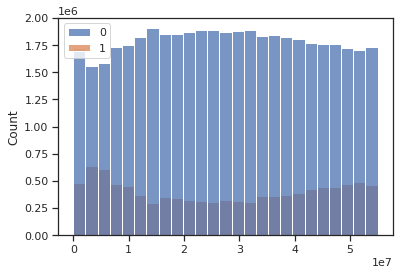

In [34]:
ax = sns.histplot([ib_idx, oob_idx], bins=25)

In [35]:
X_ib = X.iloc[ib_idx].copy()
y_ib = y[ib_idx]
X_oob  = X.iloc[oob_idx].copy()
y_oob  = y[oob_idx]

In [36]:
clusters_ib = cluster_groups[ib_idx]
clusters_oob = cluster_groups[oob_idx]

In [37]:
assert len(X_ib) == len(y_ib)
assert len(X_oob) == len(y_oob)
assert len(X_ib) + len(X_oob) == len(X)
assert len(set(X_ib.index).intersection(set(X_oob.index))) == 0

In [38]:
assert len(set(clusters_ib).intersection(set(clusters_oob))) == 0

In [ ]:
assert False  # stop in case we don't want to re-run the grid search

### Create HalvingGridSearch instance

In [41]:
group_kfold = GroupKFold(n_splits=4)

In [42]:
splits = list(group_kfold.split(X_ib, y_ib, clusters_ib))

In [43]:
rfc = RandomForestClassifier(random_state=1337, n_jobs=12)

In [44]:
np.sqrt(len(X.columns))

4.242640687119285

In [45]:
param_grid = {"min_samples_split": [2, 10, 20, 50, 100, 200],
              "min_samples_leaf": [1, 10, 20, 50, 100],
              "max_features": [3, 4, 5, 6]}

In [46]:
smart_param_grid = []
for mf in param_grid["max_features"]:
    for mss in param_grid["min_samples_split"]:
        for msl in param_grid["min_samples_leaf"]:
            if mss > msl:
                smart_param_grid.append(
                    {"min_samples_split": [mss],
                     "min_samples_leaf": [msl],
                      "max_features": [mf]})

In [47]:
len(smart_param_grid)

64

In [48]:
hgs = HalvingGridSearchCV(rfc, smart_param_grid, resource="n_estimators", max_resources=100, min_resources=11, random_state=1337, cv=splits, scoring="roc_auc", n_jobs=4, verbose = 2)

In [ ]:
search = hgs.fit(X_ib, y=y_ib)

n_iterations: 3
n_required_iterations: 4
n_possible_iterations: 3
min_resources_: 11
max_resources_: 100
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 64
n_resources: 11
Fitting 4 folds for each of 64 candidates, totalling 256 fits


In [51]:
search.best_params_

{'max_features': 6,
 'min_samples_leaf': 10,
 'min_samples_split': 20,
 'n_estimators': 99}

In [45]:
rfc_best = search

### Apply to Out of Bag Sample (without having to rerun previous code)

In [39]:
rfc_best = RandomForestClassifier(random_state=1337, n_jobs=34, n_estimators=100, max_features=6, min_samples_split=20, min_samples_leaf=10)

In [40]:
rfc_best.fit(X_ib, y_ib)

RandomForestClassifier(max_features=6, min_samples_leaf=10,
                       min_samples_split=20, n_jobs=34, random_state=1337)

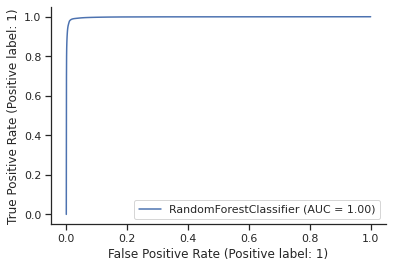

In [41]:
# Plot Out-of-bag
plot_roc_curve(rfc_best, X_oob, y_oob)
sns.despine()

In [42]:
y_pred_ob = rfc_best.predict_proba(X_oob)[:, 1]

In [43]:
roc_auc_score(y_oob, y_pred_ob)

0.998071698922542

### Get threshold / FPR/TRP tradeoffs

In [44]:
fpr, tpr, thresholds = roc_curve(y_oob, y_pred_ob, pos_label=1)

In [52]:
tprint = [0.1, 0.05, 0.04, 0.03, 0.02, 0.01, 0.005, 0.001, 0.0006, 0.0005, 0.00044, 0.0001]
pf, pt, ptr = fpr[0], tpr[0], thresholds[0]
next_threshold = tprint.pop()
for f, t, tr in zip(fpr, tpr, thresholds):
    if f == pf:
        pf, pt, ptr = f, t, tr
    else:
        if f > next_threshold:
            print(pf, pt, ptr)
            if not tprint:
                break
            next_threshold = tprint.pop()
        pf, pt, ptr = f, t, tr


9.99732024492843e-05 0.31383974197054476 0.9999758608485391
0.00043992152793758044 0.6295523547041335 0.9977140750076137
0.0004998660122464215 0.6612452401811822 0.9970986370671657
0.0005998392146957058 0.7051255886242721 0.9959424758769573
0.0009999292102964906 0.8058544070731336 0.9901977952256176
0.0049998432372861 0.9451598674043782 0.9117517963952213
0.009999883660375849 0.976428606217781 0.7263129812449926
0.019999964506555345 0.9885687445909469 0.3364582499590652
0.02999984816693119 0.9913362473451396 0.20345529865913195
0.03999815434087786 0.9929563259079075 0.1409625768838606
0.04999744644384276 0.994404852821502 0.10187613198954784
0.09999962534697307 0.9973261605025399 0.033566071279965415


In [46]:
pf, pt, ptr = fpr[0], tpr[0], thresholds[0]
for f, t, tr in zip(fpr, tpr, thresholds):
    if ptr < 0.99:
        print(pf, pt, ptr)
        if not tprint:
            break
        next_threshold = tprint.pop()
    pf, pt, ptr = f, t, tr


0.0010137322165518158 0.8077915604081667 0.9899978805040932


In [47]:
pf, pt, ptr = fpr[0], tpr[0], thresholds[0]
for f, t, tr in zip(fpr, tpr, thresholds):
    if f == pf:
        pf, pt, ptr = f, t, tr
    if tr <= 0.99:
        print(pf, pt, ptr)
        print(f, t, tr)
        break

0.0 0.0 2.0
0.0010137322165518158 0.8077734193142312 0.99


In [48]:
len(y_oob)

10142718

<AxesSubplot:>

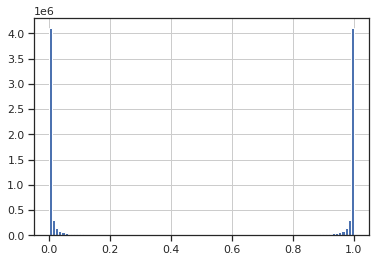

In [49]:
pd.Series(y_pred_ob).hist(bins=100)

In [50]:
# what is it for in-bag?
roc_auc_score(y_ib, rfc_best.predict_proba(X_ib)[:, 1])

0.9995819561366006